### Outline of notebook:

#### 2.1 Formatting notebook environment and importing dataset
#### 2.2 Assessing feature correlations with Churn
#### 2.3 Assessing the feature importance via Random Forest
#### 2.4 Assessing Mutual Information
#### 2.5 Exporting engineered datasets to S3 for machine learning

### Purpose of Feature Selection

In predictive modeling, there's a trade-off between the value additional features bring and the computational cost of processing them. Including irrelevant data can hinder model performance and waste time that could be better spent optimizing the model. This notebook identifies and removes features that lack predictive power, aiming to reduce dimensionality and improve model efficiency. We'll assess each feature's relationship with churn and its inherent variability. Features that perform poorly in these tests will be removed, unless there is a strong contextual reason to retain them.

### 2.1 Formatting notebook environment and importing dataset

In [38]:
# Data manipulation libraries
import pandas as pd
import numpy as np
import random as random
from sklearn.utils import shuffle
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split

# Sagemaker and other AWS libraries
import sagemaker
import sagemaker.amazon.common as smac # used to convert NumPy arrays or pandas DataFrames into RecordIO protobuf format, which is the format expected by many of SageMaker's algorithms for efficient training.
import boto3 # allows Python developers to write software that interacts with Amazon Web Services (AWS) services, such as S3, EC2, SageMaker, and many others.
from sagemaker import get_execution_role
import os

# Data visualization libraries
import matplotlib as mat
import matplotlib.pyplot as plt    
import seaborn as sns
%matplotlib inline

# Importing some basic machine learning libraries to test feature importance
from sklearn.ensemble import RandomForestClassifier as rfc
import statsmodels.api as sm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Defining some variables for Sagemaker session
region = boto3.Session().region_name
smclient = boto3.Session().client('sagemaker')
role = get_execution_role()
region, smclient, role

('us-east-1',
 'arn:aws:iam::339712697475:role/SageMakerExecutionRole')

In [2]:
# 500 rows and 200 columns will be presented
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 500)

In [3]:
# Read in our dataset
def CSV_Reader(bucket, subfolder, source_file_name):
    
    '''The CSV_Reader() function takes in the names of the bucket, subfolder, and source file name, and desired dataframe name. 
    It first constructs the filepath, and then imports the file residing at this filepath, based on the title fed to the function.
    
    Arguments 
    --------- 
    bucket: Head S3 repository bucket
    subfolder: Subfolder containing the source data
    source_file_name: Name of source CSV data file 
    
    Return
    ---------
    Returns the source data in a pandas dataframe '''
    
    data_location = 's3://{}/{}/{}'.format(bucket, subfolder, source_file_name)  
    dataset = pd.read_csv(data_location, low_memory=False)
    return dataset

In [4]:
bucket = 'user-churn'
subfolder = 'user-churn-processed-data'
input_file_name = 'prepared_data.csv'
reduced_dimensions_data_train = 'reduced_dimensions_data_train.csv'
reduced_dimensions_data_test = 'reduced_dimensions_data_test.csv'

In [5]:
data = CSV_Reader(bucket, subfolder, input_file_name)

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/fsspec/registry.py:279: UserWarning: Your installed version of s3fs is very old and known to cause
severe performance issues, see also https://github.com/dask/dask/issues/10276

To fix, you should specify a lower version bound on s3fs, or
update the current installation.

  warnings.warn(s3_msg)


In [6]:
data.drop(columns=['LastVideoWatched'], axis=1, inplace=True)

In [7]:
data.sample(5)

,VideosWatched,LikesGiven,CommentsMade,TimeSpent,AverageSessionDuration,TotalSessions,ProfileCompleteness,VideoUploads,VideoShares,LoginFrequency,AdInteractions,InAppPurchases,SupportTickets,EngagementScore,Churn_num,Age_binned_encoded,SubscriptionStatus_encoded,AccountType_encoded,NotificationsEnabled_encoded,Gender_Male,Gender_Unknown,AppVersion_1.1,AppVersion_1.2,AppVersion_2.0,Country_Canada,Country_India,Country_UK,Country_US,DeviceType_Mobile,DeviceType_Tablet,OS_Other,OS_iOS,ReferralSource_Organic,ReferralSource_Social Media,FavoriteCategory_Meal Types,FavoriteCategory_Recipes,DaysSinceLastLogin_binned_Last Week,DaysSinceLastLogin_binned_Last Month,DaysSinceLastLogin_binned_Last 3 Months,DaysSinceLastLogin_binned_Last Year
96962,0.228805,0.982427,0.458552,0.451673,0.574926,1.370315,-1.515845,-1.873668,-2.506938,0.204280,0.669048,1.144858,0.149123,0.705270,1,0,1,0,1,True,False,False,True,False,False,False,False,True,True,False,False,True,False,False,False,True,False,False,True,False
74315,-2.448722,-0.881854,0.709894,-1.760690,0.833597,-1.369800,0.455094,1.574625,0.669560,0.204280,-1.136255,-1.456525,0.149123,-1.235999,1,0,1,0,0,False,False,False,True,False,False,False,False,True,True,False,False,True,True,False,False,True,True,False,False,False
155661,0.228805,0.185472,1.652741,1.312078,0.646384,-0.133009,-1.333992,0.794296,0.669560,0.204280,-0.337395,-1.091599,0.149123,0.671790,0,0,1,0,0,False,False,False,True,False,True,False,False,False,True,False,False,True,True,False,False,True,True,False,False,False
67471,0.336711,0.413815,0.458552,-0.376431,1.125069,0.393525,-1.072841,1.223742,0.229148,0.758972,1.595063,0.701621,-1.247519,0.085920,0,0,0,1,1,False,False,False,False,True,False,False,False,False,True,False,False,True,True,False,False,True,False,True,False,False
142638,-1.217760,-2.195508,-0.544410,-0.687422,1.037350,-1.771886,-0.587584,0.240643,-0.338641,-0.135956,-0.337395,-1.456525,-1.247519,-1.466537,0,5,0,0,1,False,False,False,True,False,False,False,False,True,False,False,False,True,False,True,False,False,False,True,False,False


In [8]:
X = data.drop(columns=['Churn_num'])
y = data['Churn_num']

### 2.2 Assessing feature correlations with Churn

Below we fit basic linear correlations between each feature and user churn. We take absolute values because we are interested in the magnitude, not the direction, of these correlations.

In [9]:
correlations = X.corrwith(y).abs().sort_values(ascending=False).reset_index()

# We rename the columns of our correlation-valur-dataset for interpretability
correlations.columns = ['feature', 'correlation with outcome']

In [10]:
correlations

,feature,correlation with outcome
0,CommentsMade,0.004663
1,TimeSpent,0.004321
2,DaysSinceLastLogin_binned_Last Week,0.003688
3,ProfileCompleteness,0.003639
4,SubscriptionStatus_encoded,0.003475
5,VideoUploads,0.003296
6,Country_UK,0.003133
7,DaysSinceLastLogin_binned_Last Month,0.003020
8,InAppPurchases,0.003006
9,LoginFrequency,0.002780


Before removing any feature, we should try other methods like feature importance.

### 2.3 Assessing the Feature Importance via Random Forest

Similar to the linear correlation values above, by running a basic random forest on the variables, we can determine the relative degree of influence of the variables on the forecast.

In [26]:
rfc = rfc()
# rfc.set_params(n_estimators=200, min_samples_split=5, min_samples_leaf=1, max_features='sqrt', max_depth=60)
rfc.fit(X, y)

RandomForestClassifier()

In [27]:
importance = rfc.feature_importances_

/tmp/ipykernel_14288/2536589654.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', palette=palette, data=feature_importances)
/tmp/ipykernel_14288/2536589654.py:7: UserWarning: 
The palette list has fewer values (1) than needed (40) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x='Importance', y='Feature', palette=palette, data=feature_importances)


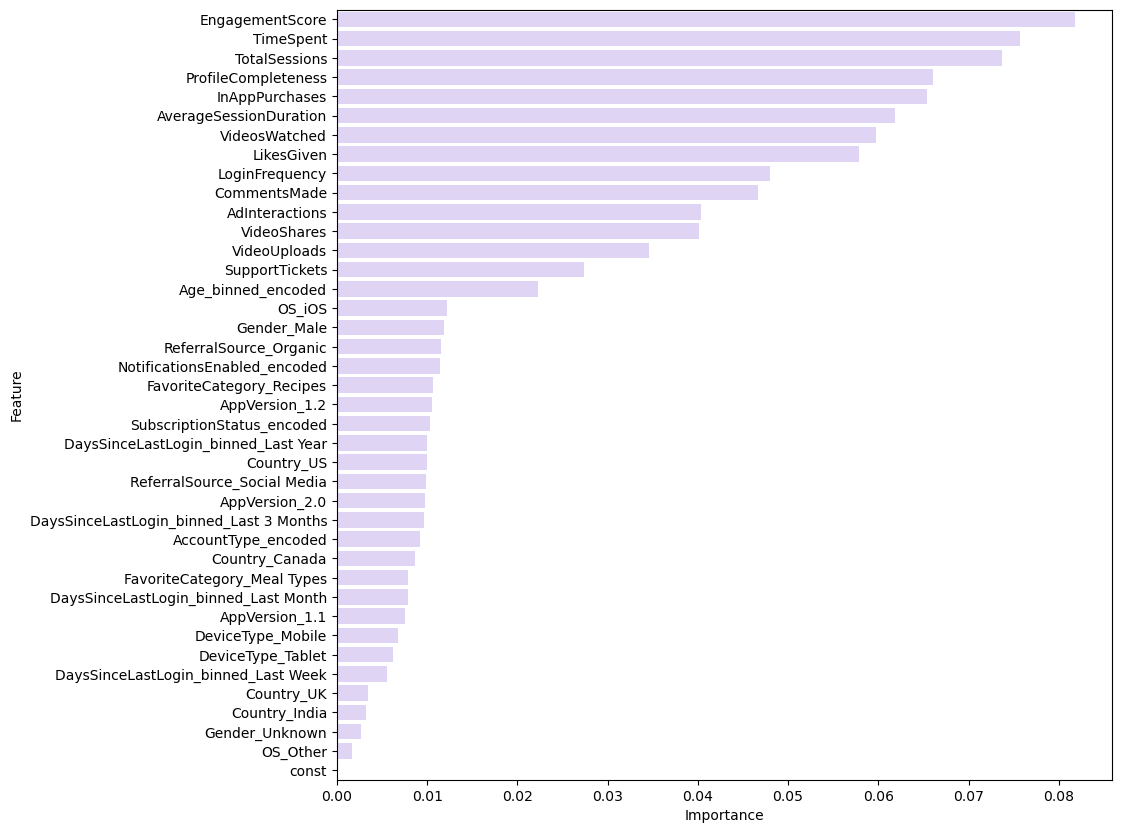

In [30]:
palette = ['#decffa']

# create a DataFrame with feature names and importances
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importance})
feature_importances = feature_importances.sort_values('Importance', ascending=False)
plt.figure(figsize=(10, 10))
sns.barplot(x='Importance', y='Feature', palette=palette, data=feature_importances)
plt.show()

In [14]:
feature_importances

,Feature,Importance
13,EngagementScore,0.082036
3,TimeSpent,0.075960
5,TotalSessions,0.073413
6,ProfileCompleteness,0.066482
11,InAppPurchases,0.064751
0,VideosWatched,0.060334
4,AverageSessionDuration,0.060295
1,LikesGiven,0.058122
9,LoginFrequency,0.048056
2,CommentsMade,0.045631


### 2.4 Assessing Mutual Information

Mutual Information is a non-parametric method that measures the dependency between each feature and the target variable (churn). It works well with both categorical and continuous variables, making it a versatile option for short-video apps, where data may include a mix of user demographics, app interactions, and behavioral metrics.

In [31]:
mi = mutual_info_classif(X, y, discrete_features='auto')
# Convert the result into a pandas Series for easier interpretation
mi_series = pd.Series(mi, index=X.columns)

In [32]:
mi_series_sorted = mi_series.sort_values(ascending=False)

print("Top features based on Mutual Information:")
print(mi_series_sorted)

Top features based on Mutual Information:
const                                      0.020857
Country_US                                 0.020051
OS_iOS                                     0.018346
NotificationsEnabled_encoded               0.018105
FavoriteCategory_Recipes                   0.017609
DeviceType_Mobile                          0.015989
ReferralSource_Organic                     0.015720
DaysSinceLastLogin_binned_Last Year        0.012191
Gender_Male                                0.011804
AppVersion_1.2                             0.011786
AppVersion_2.0                             0.004645
Age_binned_encoded                         0.004388
DaysSinceLastLogin_binned_Last 3 Months    0.003922
SupportTickets                             0.003538
ReferralSource_Social Media                0.003401
Country_Canada                             0.003092
AverageSessionDuration                     0.002705
AccountType_encoded                        0.002560
DaysSinceLastLogin_bin

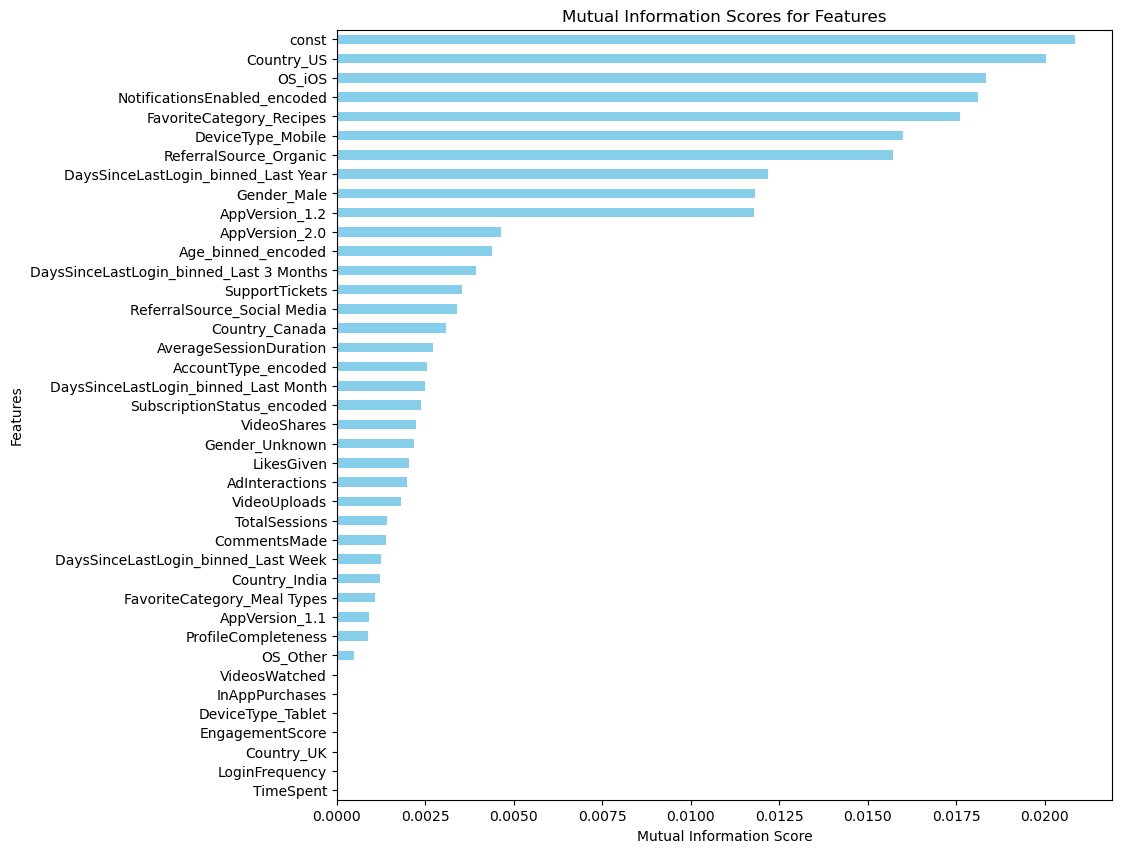

In [35]:
plt.figure(figsize=(10, 10))
mi_series_sorted[::-1].plot(kind='barh', color='skyblue')
plt.title('Mutual Information Scores for Features')
plt.ylabel('Features')  # Label for the vertical axis (which now represents the features)
plt.xlabel('Mutual Information Score')  # Label for the horizontal axis
plt.show()

Based on the results from different methods (Correlation, Random Forest Feature Importance, and Mutual Information), we can select features that are consistently identified as important. 

Consider Dropping: AppVersion_1.1, DeviceType_Tablet, OS_Other, Country_India, Country_UK, LikesGiven.

In [36]:
data.drop(columns=['AppVersion_1.1', 'DeviceType_Tablet', 'OS_Other', 'Country_India', 'Country_UK', 'LikesGiven'], axis=1, inplace=True)

In [37]:
data.shape

(155732, 34)

### 2.5 Exporting engineered datasets to S3 for machine learning

we will split this data into a 80% train/validation dataset, and a residual 20% holdout test dataset for our final evaluation.

In [39]:
# Split the dataset into 80% train/validation and 20% test
train_data, test_data = train_test_split(data, test_size=0.20, random_state=42)

# Check the shapes of the resulting datasets
print(train_data.shape)
print(test_data.shape)

(124585, 34)
(31147, 34)


In [40]:
def Export_Processed_CSV(bucket, processed_data_folder, local_file_name, S3_file_name, header_presence):
    '''Exports a dataframe into CSV format, and sends to a specified S3 bucket location
    
    Arguments 
    --------- 
    bucket: A list of the columns (i.e. the 3 diagnosis columns) to be updated
    processed_data_folder: the relevant subfolder within the main bucket
    local_file_name: The name of the dataframe within the notebook
    S3_file_name: The name of the file uppn export (with .csv extension included)
    header_presence: whether or not a header will be present within the exported csv
    
    Return
    ---------
    Exports a csv file to a specified S3 location'''
    
    local_file_name.to_csv(S3_file_name, index=False, header=header_presence)
    boto3.Session().resource('s3').Bucket(bucket).Object('{}/{}'.format(processed_data_folder, S3_file_name)).upload_file(S3_file_name)

In [42]:
Export_Processed_CSV(bucket, subfolder, train_data, reduced_dimensions_data_train, True)
Export_Processed_CSV(bucket, subfolder, test_data, reduced_dimensions_data_test, True)

Please continue to the third script in this repository: 3. Model_Tuning_Deployment_Predictions